<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/01_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# グラフ表現

---



グラフ構造とは,ノード(点)とエッジ（辺）からなるデータ構造です.  
グラフは"何か"と"何か"の繋がりを表現することができ,様々なものをグラフとして表現できます.

代表的なグラフはソーシャルネットワークです. 人と人との繋がり(友達，家族など)をグラフとして表現することができます.  
化合物(原子と原子の繋がり)や, 骨格(関節と関節の繋がり)などもよくグラフとして表現されます.

他にも
*   路線図
*   論文の引用関係
*   神経
*   感染経路
*   インターネット

など，グラフは様々なものを表現できる強力なデータ構造です.



<!-- 
<img src='https://drive.google.com/uc?id=10dTyPYS8xJ2NPENXUG8rQd_sYqltvPTB' width=80%> 
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/01_graph.png?raw=true' width=80%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/01_graph.png?raw=true' width=80%>

# グラフの表現方法


---




グラフを畳み込む(Graph convolution)ことで, グラフから特徴を抽出することができます.

その前に， グラフは強力な表現方法である一方, プログラミングで扱うのは画像などと比べるとやや手間がかかります.  
今回は, グラフを描画しながら， グラフの表現方法について知る機会とします.


グラフ構造を簡単に扱うためのモジュールをインストールします.
 - Deep Graph Library (DGL) ：　グラフ向けのDeep Learningのライブラリです．Graph Convolutionなども簡単に扱うことができます.
 - networkx : グラフ理論を扱いやすくするパッケージです. ここではグラフの描画に使用します.

In [ ]:
pip install dgl \
pip install networkx

     |████████████████████████████████| 3.5MB 4.6MB/s 


インストールしたモジュールと今回使用するモジュールもインポートしておきます. 


In [ ]:
import torch
import dgl
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import coo_matrix

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


描画を頻繁に行うので，あらかじめ描画用の関数を作っておきます.

In [ ]:
# グラフ描画の関数
def plot_graph(dgl_g):
    print('ノードの配列 :　', dgl_g.nodes())
    print('ノードの数   :　', dgl_g.number_of_nodes())
    print('エッジの配列　:　', dgl_g.edges())
    print('エッジの本数　：　', dgl_g.number_of_edges())

    #DGLを使ったグラフから, networkxを使ったグラフに変換します.
    nx_g = dgl_g.to_networkx() 
    #描画します
    nx.draw_networkx(nx_g, node_size=500, node_color=[[1.0, 0.45, 0.45]])
    plt.show()

### グラフ作成　はじめ

---



DGLを使ってグラフを作ります．  
グラフの表現方法は様々ありますが，単縦な配列（集合）を使ってグラフを定義します．  
以下のようなグラフを目指して, 作成してみます.

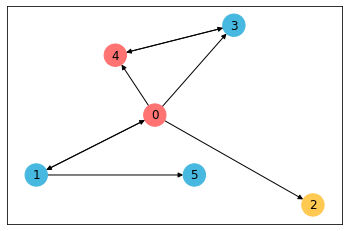

まず，0番,1番ノードを,エッジの定義をすることでグラフ化します.　　　

DGLでは,ノードをあらかじめ定義しなくても，エッジだけでもグラフを作ることができます.

ノードの配列 :　 tensor([0, 1])
ノードの数   :　 2
エッジの配列　:　 (tensor([0]), tensor([1]))
エッジの本数　：　 1


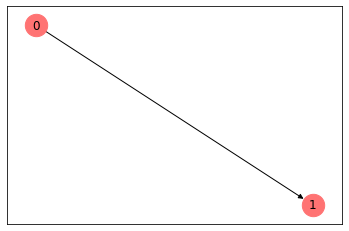

In [ ]:
u = torch.tensor([0]) #エッジの始点となるノード
v = torch.tensor([1]) #エッジの終点となるノード
dgl_g = dgl.graph((u, v)) #グラフ化
plot_graph(dgl_g) #グラフ描画

０番ノードから1番ノードへのエッジが伸びているグラフが生成できました.  
エッジのみを定義することで，自動でノードが生成されています.

一緒にprintされた配列(集合)を見ます.  
ノードの配列には{0, 1}という2つの要素です.  
エッジの配列には{{0},{1})}になっています. 
エッジの集合表現にも様々ありますが, DGLでのエッジ集合の要素は{{始点の集合},{終点の集合})になります.

###有向グラフ, 無向グラフ

完成予定のグラフを見ると, 0->1方向に矢印があり, 1->0方向にも矢印があるのが分かるでしょうか.  
グラフには有向グラフと無向グラフがあります.　　

有向グラフは, エッジに向きがあるグラフです.  
無向グラフは, 全てのエッジに向きがないグラフです. (または全てのエッジが双方のノードに向いているとも言えます)　　  

完成予定のグラフのように, 双方向のエッジと，片方のエッジが混在しているようなグラフも有向グラフと呼ぶことが多いです.


0番と1番ノードの双方向にエッジが伸びるように，エッジの配列に要素を追加します.　　  
0->1へのエッジは既にあるので, 1->0へのエッジの要素を追加します.

ノードの配列 :　 tensor([0, 1])
ノードの数   :　 2
エッジの配列　:　 (tensor([0, 1]), tensor([1, 0]))
エッジの本数　：　 2


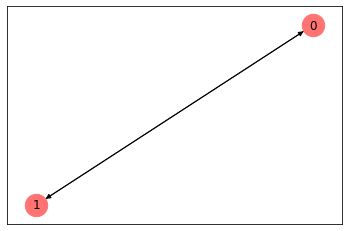

In [ ]:
# 1->0のエッジを追加
dgl_g.add_edges(v,u) # 先ほど作った始点と終点を入れ替えて, エッジを追加します.

#　グラフ描画
plot_graph(dgl_g)

描画されたグラフには,双方向に矢印が向いています.  
エッジの配列が {(0,1), (1,0)}になりました．  
繰り返しですが, DGLでのエッジ集合の要素は{{始点の集合},{終点の集合})になります.




---



次に，あらかじめノードを定義してから，エッジを追加します.

ノードの配列 :　 tensor([0, 1, 2, 3])
ノードの数   :　 4
エッジの配列　:　 (tensor([0, 1]), tensor([1, 0]))
エッジの本数　：　 2


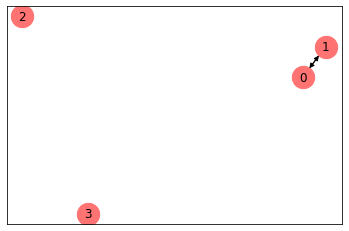

ノードの配列 :　 tensor([0, 1, 2, 3])
ノードの数   :　 4
エッジの配列　:　 (tensor([0, 1, 0, 0]), tensor([1, 0, 2, 3]))
エッジの本数　：　 4


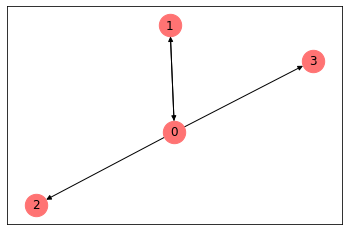

In [ ]:
# ノードを新たに2つ追加します. 
dgl_g.add_nodes(2) 
 #この時点で描画すると, エッジがないノードが見えます.
plot_graph(dgl_g)

# 0と2, 0と3のノードが繋がっているのでエッジを追加します
dgl_g.add_edges([0, 0], [2, 3]) #(始点の配列, 終点の配列)のように与えます.
# また2つのエッジは0が始点のため dgl_g.add_edges[0, [2, 3]]　　のように書くこともできます.
plot_graph(dgl_g) # グラフ描画

###ノード特徴, ラベル

---



今作っているグラフのノードは中身が空っぽです.  
本来はノードに様々な情報が入りグラフが完成します.　  

例えば,ソーシャルグラフであれば,ノードは人間です．  
ノード特徴には,年齢や，身長，体重などのデータが入っているかもしれません．  
また,エッジには交友関係(０番と1番は友達)といったラベルが入ることも考えられます.

ノードとエッジに,ラベルや特徴を付与してみます.

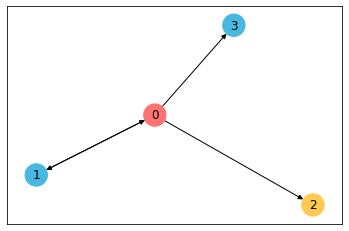

In [ ]:
# 今回はノード特徴として， 色(RGB)を割り当ててみます. 一気に4ノードに割り当てます.
dgl_g.ndata['color'] = torch.tensor([[1.0, 0.45, 0.45], [0.28, 0.72, 0.88], [1.0, 0.79, 0.32], [0.28, 0.72, 0.88]])

# さらにノード特徴として， xy座標を割り当ててみます. 一つずつ割り当てる方法もあります.
dgl_g.nodes[0].data['coord'] = torch.tensor([[0.5, 0.5]])
dgl_g.nodes[1].data['coord'] = torch.tensor([[0.2, 0.3]])
dgl_g.nodes[2].data['coord'] = torch.tensor([[0.9, 0.2]])
dgl_g.nodes[3].data['coord'] = torch.tensor([[0.7, 0.8]])

# 次にエッジにも特徴を割り当てることができます. 今回は使わないので自由に割り当てます.
dgl_g.edata['x'] = torch.ones(dgl_g.number_of_edges(), 3)

# 色と座標を使って, 描画してみます.
# 座標は, 辞書型にしないと描画に使えないので，辞書型として取り出します.
pos_ = {n.item(): (dgl_g.nodes[n].data['coord'][0][0], dgl_g.nodes[n].data['coord'][0][1]) for n in dgl_g.nodes()}

# 描画
nx.draw_networkx(dgl_g.to_networkx(), pos=pos_, node_size=500, node_color=dgl_g.ndata['color'])
#nx.draw_networkx(dgl_g.to_networkx(), node_size=500, node_color=dgl_g.ndata['color']) # 座標を与えずに描画
plt.show()


ここで, 座標を使わずに何回か描画を行ってみて下さい.  
毎回違う形のグラフが描画されます(接続関係は同じ)．   

今回は座標を与えてみましたが，本来はノードが空間内のどこにいても構いません.  
ソーシャルネットワークの場合, ０番という人が画面の端に居ても中心に居ても変わりません. 必要なのは接続関係だけなはずです.  

あくまで, グラフというのはノードの位置ではなく, 接続関係が重要なのです.

###グラフ完成

---



目標のグラフを完成させましょう．  
あと2つノードが足りません.
ノード追加と特徴追加を同時に定義してみます.


ノードの配列 :　 tensor([0, 1, 2, 3, 4, 5])
ノードの数   :　 6
エッジの配列　:　 (tensor([0, 1, 0, 0, 0, 1, 3, 4]), tensor([1, 0, 2, 3, 4, 5, 4, 3]))
エッジの本数　：　 8


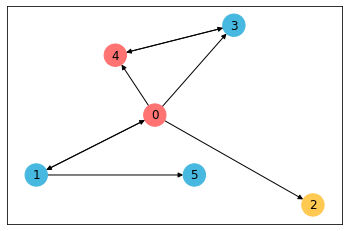

In [ ]:
# ノードを2つ追加. 同時に2つ分の色(color)とxy座標(coord)も与えます.
dgl_g.add_nodes(2, {'color': torch.tensor([[1.0, 0.45, 0.45], [0.28, 0.72, 0.88]]), 'coord': torch.tensor([[0.4, 0.7], [0.6, 0.3]])})
# エッジの追加
dgl_g.add_edges([0, 1, 3, 4], [4, 5, 4, 3])


print('ノードの配列 :　', dgl_g.nodes())
print('ノードの数   :　', dgl_g.number_of_nodes())
print('エッジの配列　:　', dgl_g.edges())
print('エッジの本数　：　', dgl_g.number_of_edges())


# 座標は, 辞書型にしないと描画に使えないので，辞書型として取り出します.
pos_ = {n.item(): (dgl_g.nodes[n].data['coord'][0][0], dgl_g.nodes[n].data['coord'][0][1]) for n in dgl_g.nodes()}
# 描画
nx.draw_networkx(dgl_g.to_networkx(), pos=pos_, node_size=500, node_color=dgl_g.ndata['color'])
plt.show()

目標のグラフが完成しました.

# 隣接行列（グラフの表現方法）

---



ここまでは，グラフの接続関係を配列（集合）として定義してきました.  

グラフを表現するもう一つの代表的な方法として，隣接行列があります．  
隣接行列は,後々のグラフ畳み込み処理でも使用するので，確認しておきます.  
今まで作ってきたグラフから，隣接行列を取り出します.

In [ ]:
print(dgl_g.adjacency_matrix().to_dense().numpy())

[[0. 1. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


6(ノード数)×6（ノード数）の行列が出力されました.  
この行列だけでグラフの接続関係を表現しています.

０行目は0番ノードの接続関係を示しています.   
０行目の1, 2, 3, 4列目に「１」が入っています.
完成したグラフを見ると0番ノードから1,2,3,4番ノードにエッジが伸びているはずです.

同様に1行目のは１番ノードの接続関係を示します.  
1行目の0,5列目に「１」が入っています.
完成したグラフを見ると１番ノードから0,5番ノードにエッジが伸びているはずです.

隣接行列はグラフの接続関係を表現していることがわかったでしょうか.  
グラフを編集すれば, 隣接行列も変わります.

###隣接行列からグラフを作成

隣接行列はグラフの接続関係を表現しているため, 隣接行列からもグラフを作成することができるはずです.

隣接行列を変更することでグラフを編集することもできます.  
隣接行列を自由に編集してグラフを作ってみましょう.
ノード数（行列の大きさ）を変更しても大丈夫です.

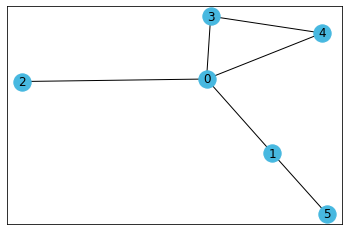

In [ ]:
# 手動で隣接行列を編集できます.
adj = [[0, 1, 1, 1, 1, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0]]
adj = np.array(adj)

#隣接行列からグラフを生成
G = nx.convert_matrix.from_numpy_array(adj)
nx.draw_networkx(G, node_color=[[0.28, 0.72, 0.88]])
plt.show()

[[0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0]
 [1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1 1]
 [0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1]
 [0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0]
 [0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1]
 [1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0]
 [1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1]
 [1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1]
 [0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0]
 [0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0]
 [1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1]
 [0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1]
 [1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0]
 [0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0]
 [0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0]
 [0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 1]
 [1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1]
 [1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1]
 [1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0]]


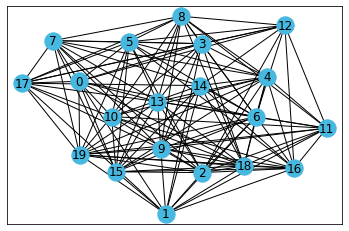

In [ ]:
# ランダムで隣接行列を生成します.
num_node = 20
adj = np.random.randint(0, 2, (num_node, num_node))
print(adj)

#隣接行列からグラフを生成
G = nx.convert_matrix.from_numpy_array(adj)
nx.draw_networkx(G, node_color=[[0.28, 0.72, 0.88]])
plt.show()